In [265]:
#imports
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline
%config inlineBackend.figure_format='retina'


In [474]:
#preproccessing
data = pd.read_csv("BTC-USD-Daily-With-Sentiment.csv", index_col ='Date', parse_dates=True)
display(data.head(5))

,Open,High,Low,Sentiment,Close
Date,,,,,
2021-04-17,61529.92188,62572.17578,60361.35156,76,60683.82031
2021-04-18,60701.88672,61057.45703,52829.53516,79,56216.18359
2021-04-19,56191.58594,57520.05469,54368.59375,74,55724.26563
2021-04-20,55681.79297,57062.14844,53448.04688,73,56473.03125
2021-04-21,56471.12891,56757.97266,53695.46875,73,53906.08984


<AxesSubplot:title={'center':'btc close'}, xlabel='Date'>

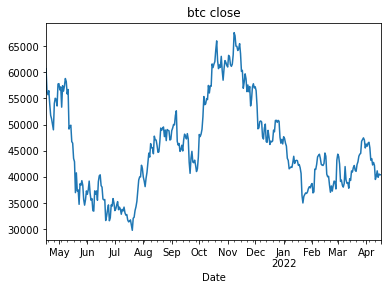

In [587]:
data['Close'].plot(label='Close', title='btc close')

In [476]:
# del data['Adj Close']

In [477]:
# data=data.iloc[:, [0,3,4]]
# display(data.head(5))


In [478]:
#splitting features and labels
x=data.iloc[:, :-1]
y=data.iloc[:, 4:5]

display(x.head(5))
display(y.head(5))

,Open,High,Low,Sentiment
Date,,,,
2021-04-17,61529.92188,62572.17578,60361.35156,76
2021-04-18,60701.88672,61057.45703,52829.53516,79
2021-04-19,56191.58594,57520.05469,54368.59375,74
2021-04-20,55681.79297,57062.14844,53448.04688,73
2021-04-21,56471.12891,56757.97266,53695.46875,73


,Close
Date,
2021-04-17,60683.82031
2021-04-18,56216.18359
2021-04-19,55724.26563
2021-04-20,56473.03125
2021-04-21,53906.08984


In [479]:
#Normalizing the data
scaler_s = StandardScaler()
scaler_mm = MinMaxScaler()

x_normalized = scaler_s.fit_transform(x)
y_normalized = scaler_mm.fit_transform(y) 

In [480]:
# splitting the data
size=int(len(x_normalized)*0.8)

X_train = x_normalized[:size, :]
X_test = x_normalized[size:, :]

y_train = y_normalized[:size, :]
y_test = y_normalized[size:, :]

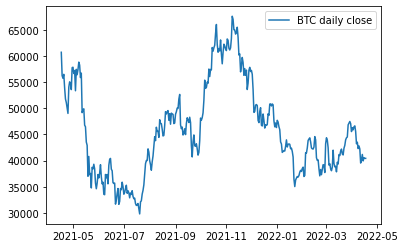

In [481]:
plt.plot(data['Close'],label='BTC daily close')
plt.legend()
plt.show()

In [482]:
print("Train set shape x,y", X_train.shape, y_train.shape)
print("Test set shape x,y ", X_test.shape, y_test.shape) 

Train set shape x,y (292, 4) (292, 1)
Test set shape x,y  (74, 4) (74, 1)


In [483]:
# transforming sets to tensors
X_train = Variable(torch.Tensor(X_train))
X_test = Variable(torch.Tensor(X_test))

y_train = Variable(torch.Tensor(y_train))
y_test = Variable(torch.Tensor(y_test)) 

In [484]:
#reshaping x tensors
X_train_f = torch.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]) )

X_test_f = torch.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]) ) 
print("Train set shape x,y", X_train_f.shape, y_train.shape)
print("Test set shape x,y ", X_test_f.shape, y_test.shape) 

Train set shape x,y torch.Size([292, 1, 4]) torch.Size([292, 1])
Test set shape x,y  torch.Size([74, 1, 4]) torch.Size([74, 1])


In [485]:
def set(x,y):
    x=x.type(torch.FloatTensor)
    y=y.type(torch.FloatTensor)
    
    train_data = []
    for i in range(len(x)):
        train_data.append([x[i], y[i]])
    return train_data

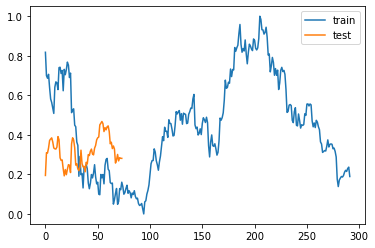

In [486]:
plt.plot(y_train.numpy(),label='train')
plt.plot(y_test.numpy(),label='test')
plt.legend()
plt.show()

In [487]:
train_set=set(X_train_f,y_train)
test_set=set(X_test_f,y_test)


testloader = torch.utils.data.DataLoader(test_set,batch_size=64, shuffle=False)
trainloader = torch.utils.data.DataLoader(train_set,batch_size=64, shuffle=False)

In [512]:
#Model
class MyLSTM(nn.Module):
    def __init__(self,n_inputs,n_hidden=256,n_layers=3):
        super().__init__()
        self.n_hidden=n_hidden
        
        self.lstm=nn.LSTM(
            input_size=n_inputs,
            hidden_size=n_hidden,
            num_layers=n_layers,
            dropout=0.2,
            batch_first=True
        )
        
        self.fc1=nn.Linear(self.n_hidden,1)
        
    def forward(self,x):
        _,(h_t,_)=self.lstm(x)
        
        x=self.fc1(h_t[-1])
        return x

In [519]:
#Init Model,criterion,optimizer
n_inputs=4 ####
model=MyLSTM(n_inputs)
criterion=nn.MSELoss()
optimizer=optim.Adam(model.parameters(),lr=0.0001)
min_validation_loss=np.Infinity
training_losses,validation_losses=[],[]

In [534]:
#Model Training

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs= 2000
steps,running_loss,test_loss=0,0,0
model.to(device)
validate_every = 50

for e in range(epochs):
    
    #training
    for inputs, labels in trainloader:
        steps+=1
        inputs, labels= inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        #testing
        if steps % validate_every == 0:
            validation_loss = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels= inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    v_loss = criterion(logps, labels)
                    validation_loss+=v_loss.item()
            
            model.train()
            
            avg_validation_loss=validation_loss/len(testloader)
            
            print(f"Epoch {e+1}/{epochs},  "
                  f"Training loss: {running_loss/validate_every:.5f},  "
                  f"Validation loss: {avg_validation_loss:.5f},  ")
            
            training_losses.append(running_loss/validate_every)
            validation_losses.append(avg_validation_loss)
            
            #Saving better model
            if avg_validation_loss<min_validation_loss:
                print(f"Saving better model")
                min_validation_loss=avg_validation_loss
                torch.save( model.state_dict(), 'lstm_model_dict.pt')
              
            running_loss = 0


Epoch 10/2000,  Training loss: 0.00054,  Validation loss: 0.00014,  
Epoch 20/2000,  Training loss: 0.00053,  Validation loss: 0.00014,  
Epoch 30/2000,  Training loss: 0.00053,  Validation loss: 0.00014,  
Epoch 40/2000,  Training loss: 0.00052,  Validation loss: 0.00015,  
Epoch 50/2000,  Training loss: 0.00054,  Validation loss: 0.00014,  
Epoch 60/2000,  Training loss: 0.00052,  Validation loss: 0.00015,  
Epoch 70/2000,  Training loss: 0.00052,  Validation loss: 0.00015,  
Epoch 80/2000,  Training loss: 0.00051,  Validation loss: 0.00015,  
Epoch 90/2000,  Training loss: 0.00054,  Validation loss: 0.00015,  
Epoch 100/2000,  Training loss: 0.00051,  Validation loss: 0.00014,  
Epoch 110/2000,  Training loss: 0.00052,  Validation loss: 0.00015,  
Epoch 120/2000,  Training loss: 0.00053,  Validation loss: 0.00014,  
Epoch 130/2000,  Training loss: 0.00053,  Validation loss: 0.00015,  
Epoch 140/2000,  Training loss: 0.00051,  Validation loss: 0.00015,  
Epoch 150/2000,  Training los

KeyboardInterrupt: 

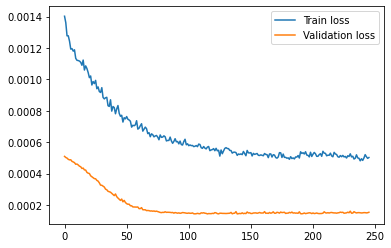

In [586]:
#plotting Losses
#removed first 10 entries for better visualization
plt.plot(training_losses[10:],label='Train loss')
plt.plot(validation_losses[10:],label='Validation loss')
plt.legend()
plt.show()

In [538]:
#Loading the best model after training
model.load_state_dict(torch.load('lstm_model_dict.pt'))

<All keys matched successfully>

In [556]:
#predicting the testing set
model.eval()
prediction=[]
labelss=[]       
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels= inputs.to(device), labels.to(device)
        logps = model.forward(inputs).cpu().data.numpy()
        prediction+=(logps.tolist())
        labelss+=labels.tolist()
        
model.train()

MyLSTM(
  (lstm): LSTM(4, 256, num_layers=3, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=256, out_features=1, bias=True)
)

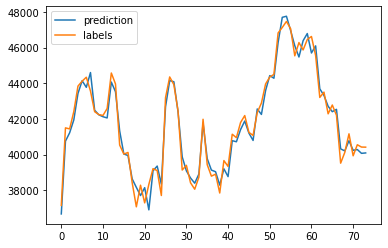

In [557]:
#plotting the predictions 
prediction_f=scaler_mm.inverse_transform(prediction) 
labels_f=scaler_mm.inverse_transform(labelss) 
plt.plot(prediction_f,label='prediction')
plt.plot(labels_f,label='labels')
plt.legend()
plt.show()

In [582]:
from sklearn.metrics import mean_squared_error,r2_score
print(f"MSE {mean_squared_error(y_true=labelss,y_pred=prediction):.7f},  "
     f"R2 Score: {r2_score(y_true=labelss,y_pred=prediction):.7f}")

MSE 0.0001639,  R2 Score: 0.9685869


In [583]:
# predicting the closing price of a day


# Apr 20, 2022 close was 41374.38
input_val = {
    'Open' : [41501.75],
    'High': [42126.30],
    'Low' : [40961.10],
    'Sentiment' : [27],
}
model.eval()
with torch.no_grad():
    tx=pd.DataFrame(input_val)
    tx = scaler_s.transform(tx)
    tx=Variable(torch.Tensor(tx))
    tx = torch.reshape(tx, (tx.shape[0], 1, tx.shape[1]) )
    model.to(torch.device('cpu'))
    pred=model.forward(tx).cpu().data.numpy()
    pred=scaler_mm.inverse_transform(pred) 
model.train()
print(pred)


[[41463.047]]


In [584]:
#Saving Model
checkpoint={'state_dict': model.state_dict(),
            'inputs': n_inputs,
            'optimizer': optimizer,
            'criterion': criterion,
            'input_scaler_standard': scaler_s,
            'output_scaler_midmax': scaler_mm,
            'model': model}
torch.save(checkpoint, 'checkpoint-sentiment.pth')